In [1]:
#Imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

### SC: Weighted Sum with pre-treatment weights (L1 Norm, Correlation, Time Shifting)
- For multiple Buildings
- Weights: L1 Norm, Correlation (Pearson product-moment correlation coefficients)
- Time Shifting
- Ensembling (Bagging, Boosting)

In [4]:
#TODO: Boosting, Correlation

class SyntheticControl:
    def __init__(self):
        self.treated_unit = None
        self.control_units = None
        self.pre_split = None
        self.Y1_pre = None
        self.Y0_pre = None
        self.Y1_post = None
        self.Y0_post = None
        self.weights = None
        self.Y_synthetic_pre = None
        self.Y_synthetic_post = None
        self.metrics = None
        self.results = None

    def prepare_data(self, path, treated_unit_idx=0, shift_range=0):
        """
        Prepare data for synthetic control analysis with optional time shifting.
        
        Args:
            path (str): Path to the CSV file
            treated_unit_idx (int): Index of the treated unit
            shift_range (int): Number of time periods to shift (0 means no shift)
        """
        # Read and prepare initial dataframe
        df = pd.read_csv(path, header=0, index_col=0, parse_dates=["date"]).sort_values('date').reset_index(drop=True)
        df = df[[col for col in df.columns if col.startswith('netconsumption')]]
        
        self.treated_unit = df.columns[treated_unit_idx]
        original_control_units = [col for col in df.columns if col != self.treated_unit]
        
        if shift_range > 0:
            # Dictionary to store all series for later concatenation
            all_series = {}
            
            # Add original data first
            all_series[self.treated_unit] = df[self.treated_unit]
            for control_unit in original_control_units:
                all_series[control_unit] = df[control_unit]
                
            # Create shifted versions for control units
            for shift in range(-shift_range, shift_range + 1):
                if shift == 0:  # Skip zero shift as it's already in original data
                    continue
                    
                # Create shifted versions for all control units at once
                for control_unit in original_control_units:
                    key = f"{control_unit}_shift{shift}"
                    all_series[key] = df[control_unit].shift(shift)
            
            # Concatenate all series at once
            shifted_df = pd.concat(all_series, axis=1)
            
            # Drop rows with NaN values from shifting
            shifted_df = shifted_df.dropna()
            
            # Create control units list - only exclude the exact treated unit
            self.control_units = [col for col in shifted_df.columns if col != self.treated_unit]
            
        else:
            shifted_df = df
            self.control_units = original_control_units
        
        # Split into pre and post treatment periods
        split_index = int(len(shifted_df) * self.pre_split)
        pre_treatment = shifted_df.iloc[:split_index].copy()
        post_treatment = shifted_df.iloc[split_index:].copy()
        
        # Prepare matrices
        self.Y1_pre = pre_treatment[self.treated_unit].values
        self.Y0_pre = pre_treatment[self.control_units].values.T
        self.Y1_post = post_treatment[self.treated_unit].values
        self.Y0_post = post_treatment[self.control_units].values.T
        
        return self
    
    def calculate_optimal_weights(self):
        
        """Calculate optimal weights using L1 norm minimization."""
        
        T0 = self.Y1_pre.shape[0]
        J = self.Y0_pre.shape[0]
        
        model = gp.Model("Synthetic_Control_L1")
        model.setParam('OutputFlag', 0)
        
        W = model.addVars(J, lb=0.0, name="W")
        e_plus = model.addVars(T0, lb=0.0, name="e_plus")
        e_minus = model.addVars(T0, lb=0.0, name="e_minus")
        
        model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1)
        
        for t in range(T0):
            discrepancy = self.Y1_pre[t] - gp.quicksum(W[j] * self.Y0_pre[j, t] for j in range(J))
            model.addConstr(discrepancy == e_plus[t] - e_minus[t])
        
        obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
        model.setObjective(obj, GRB.MINIMIZE)
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            self.weights = np.array([W[j].X for j in range(J)])
            return self.weights
        raise ValueError("Optimization failed")

    def sc_weighted_sum_pipeline(self):
        """Execute synthetic control pipeline."""
        
        if self.weights is None:
            self.calculate_optimal_weights()
            
        self.Y_synthetic_pre = np.dot(self.weights, self.Y0_pre)
        self.Y_synthetic_post = np.dot(self.weights, self.Y0_post)
        
        # Store results in a DataFrame
        pre_df = pd.DataFrame({
            'period': range(len(self.Y1_pre)),
            'actual': self.Y1_pre,
            'predicted': self.Y_synthetic_pre,
            'phase': 'pre'
        })
        
        post_df = pd.DataFrame({
            'period': range(len(self.Y1_post)),
            'actual': self.Y1_post,
            'predicted': self.Y_synthetic_post,
            'phase': 'post'
        })
        
        self.results = pd.concat([pre_df, post_df], ignore_index=True)
        self.results['building'] = self.treated_unit
        
        return self
    
    def sc_weighted_sum_bagging_pipeline(self, n_bootstrap=5, sample_fraction=0.8):
        """Execute synthetic control pipeline with bootstrap aggregating (bagging)."""
        n_controls = len(self.control_units)
        sample_size = int(n_controls * sample_fraction)
        
        # Initialize arrays for storing predictions
        pre_predictions = np.zeros((n_bootstrap, len(self.Y1_pre)))
        post_predictions = np.zeros((n_bootstrap, len(self.Y1_post)))
        
        for b in range(n_bootstrap):
            # Create bootstrap weight mask directly from sampling
            bootstrap_mask = np.bincount(np.random.choice(n_controls, size=sample_size, replace=True),minlength=n_controls) / sample_size
            
            # Calculate and adjust weights
            adjusted_weights = self.calculate_optimal_weights() * bootstrap_mask
            adjusted_weights /= adjusted_weights.sum()  # Normalize
            
            # Generate predictions
            pre_predictions[b] = np.dot(adjusted_weights, self.Y0_pre)
            post_predictions[b] = np.dot(adjusted_weights, self.Y0_post)
        
        # Average predictions and store results
        self.Y_synthetic_pre = pre_predictions.mean(axis=0)
        self.Y_synthetic_post = post_predictions.mean(axis=0)
        
        # Create results DataFrame
        self.results = pd.concat([
            pd.DataFrame({
                'period': range(len(self.Y1_pre)),
                'actual': self.Y1_pre,
                'predicted': self.Y_synthetic_pre,
                'phase': 'pre'
            }),
            pd.DataFrame({
                'period': range(len(self.Y1_post)),
                'actual': self.Y1_post,
                'predicted': self.Y_synthetic_post,
                'phase': 'post'
            })
        ], ignore_index=True)
        
        self.results['building'] = self.treated_unit
        return self

    def calculate_metrics(self):
        """Calculate performance metrics."""
        if self.results is None:
            raise ValueError("Run sc_weighted_sum_pipeline first")
            
        post_mask = self.results['phase'] == 'post'
        post_actual = self.results.loc[post_mask, 'actual']
        post_predicted = self.results.loc[post_mask, 'predicted']
        
        mae = np.mean(np.abs(post_actual - post_predicted))
        mse = np.mean((post_actual - post_predicted) ** 2)
        rmse = np.sqrt(mse)
        
        self.metrics = pd.DataFrame({
            'building': [self.treated_unit],
            'mae': [mae],
            'mse': [mse],
            'rmse': [rmse]
        })
        
        return self.metrics

    def plot_results(self, title_suffix="", periods_to_plot=3*48):
        
        """Plot results for the current synthetic control estimate."""
        
        pre_actual = self.Y1_pre[-periods_to_plot:]
        pre_synthetic = self.Y_synthetic_pre[-periods_to_plot:]
        post_actual = self.Y1_post[:periods_to_plot]
        post_synthetic = self.Y_synthetic_post[:periods_to_plot]
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 3))
        
        # Pre-Treatment Plot
        axes[0].plot(range(1, periods_to_plot + 1), pre_actual, 'bo-', label='Treated Unit', markersize=3)
        axes[0].plot(range(1, periods_to_plot + 1), pre_synthetic, 'rx--', label='Synthetic Control', markersize=3)
        axes[0].set_title(f'Pre-Treatment Period {title_suffix}')
        axes[0].set_xlabel('Period')
        axes[0].set_ylabel('Outcome')
        axes[0].legend()
        axes[0].grid(True)
        
        # Post-Treatment Plot
        axes[1].plot(range(1, periods_to_plot + 1), post_actual, 'bo-', label='Treated Unit', markersize=3)
        axes[1].plot(range(1, periods_to_plot + 1), post_synthetic, 'rx--', label='Synthetic Control', markersize=3)
        axes[1].set_title(f'Post-Treatment Period {title_suffix}')
        axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Outcome')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return self

    @staticmethod
    def aggregate_results(results_list, metrics_list):
        """ Aggregate results from multiple buildings into a consolidated format. """
        
        columns = []
        data_frames = []
        
        # Process each building's results
        for i, df in enumerate(results_list, 1):
            values = df[['actual', 'predicted']].copy()
            values.columns = [f'true_val_bld_{i}', f'pred_val_bld_{i}']
            data_frames.append(values)
            
        # Combine all buildings horizontally
        sc_values = pd.concat(data_frames, axis=1)
        
        # Process metrics
        sc_metrics = pd.concat(metrics_list, ignore_index=True)
        
        # Calculate aggregated statistics
        numeric_cols = sc_metrics.select_dtypes(include=[np.number]).columns
        sc_aggregated_stats = pd.DataFrame({
            'metric': numeric_cols,
            'mean': sc_metrics[numeric_cols].mean(),
            'std': sc_metrics[numeric_cols].std(),
            'min': sc_metrics[numeric_cols].min(),
            'max': sc_metrics[numeric_cols].max()
        }).round(4)
        
        return sc_values, sc_metrics, sc_aggregated_stats

    @staticmethod
    def save_results(sc_values, sc_metrics, sc_aggregated_stats, save_path):
        """Save aggregated results to CSV files."""
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        # Save all three dataframes
        sc_values.to_csv(os.path.join(save_path, 'sc_values.csv'), index=False)
        sc_metrics.to_csv(os.path.join(save_path, 'sc_metrics.csv'), index=False)
        sc_aggregated_stats.to_csv(os.path.join(save_path, 'sc_aggregated_stats.csv'), index=False)

    @classmethod
    def run_sc_weighted_sum_multiple_buildings(cls, config):
        """ Run synthetic control analysis for multiple buildings. """
        
        results_list = []
        metrics_list = []
        
        for building_idx in config['buildings_range']:

            print(f"Building {building_idx}")

            sc = cls()
            sc.pre_split = config['pre_split']
            
            # Execute pipeline
            sc.prepare_data(config['data_path'], building_idx, config["shift_range"])
            if config["bagging"]:
                sc.sc_weighted_sum_bagging_pipeline(n_bootstrap=3, sample_fraction=0.8)
            else:
                sc.sc_weighted_sum_pipeline()
            sc.calculate_metrics()
            
            # Store results
            results_list.append(sc.results)
            metrics_list.append(sc.metrics)
            
            # Visualize if requested
            if config['visualize']:
                print(sc.metrics)
                sc.plot_results(title_suffix=f"Building {building_idx}", periods_to_plot=config.get('periods_to_plot', 3*48))
        
        # Aggregate results
        sc_values, sc_metrics, sc_aggregated_stats = cls.aggregate_results(results_list, metrics_list)
        
        # Save results if path provided
        if config.get('save_path'):
            cls.save_results(sc_values, sc_metrics, sc_aggregated_stats, config['save_path'])
            
        return sc_values, sc_metrics, sc_aggregated_stats

Building 0
Set parameter Username
Set parameter LicenseID to value 2593432
Academic license - for non-commercial use only - expires 2025-11-30
           building       mae       mse      rmse
0  netconsumption_1  0.294097  0.165698  0.407061


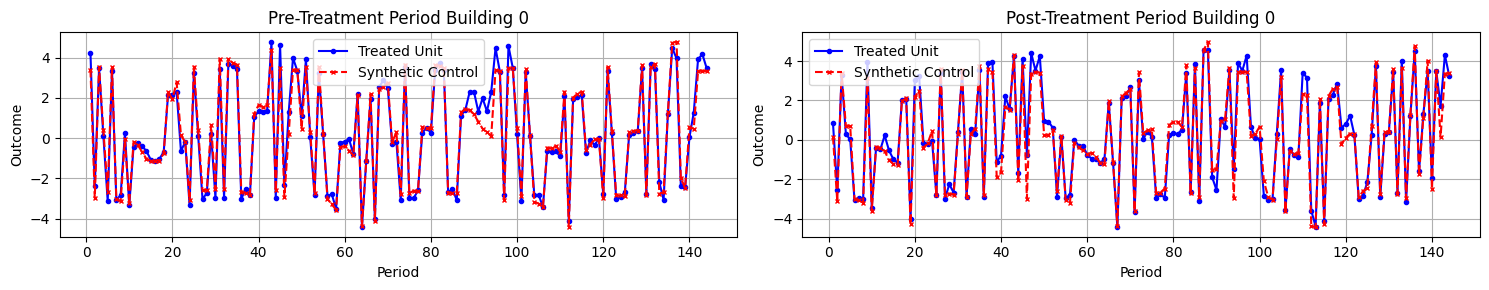

Building 1


KeyboardInterrupt: 

In [6]:
CONFIG = {
        'data_path': '../../data/Energy_dataset_bessScaled.csv',
        'buildings_range': range(2),  # Process buildings 1 and 2
        'shift_range': 0,
        'weight_type': "optimal",
        'pre_split': 0.7,
        'save_path': "results/",
        'visualize': True,
        'periods_to_plot': 3*48,
        'bagging': False
    }
    
sc = SyntheticControl()
sc_values, sc_metrics, sc_aggregated_stats = sc.run_sc_weighted_sum_multiple_buildings(CONFIG)